<a href="https://colab.research.google.com/github/chjohnso-um/chjohnso-um-CSC-587/blob/main/Model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model performance comparison between BL and V06

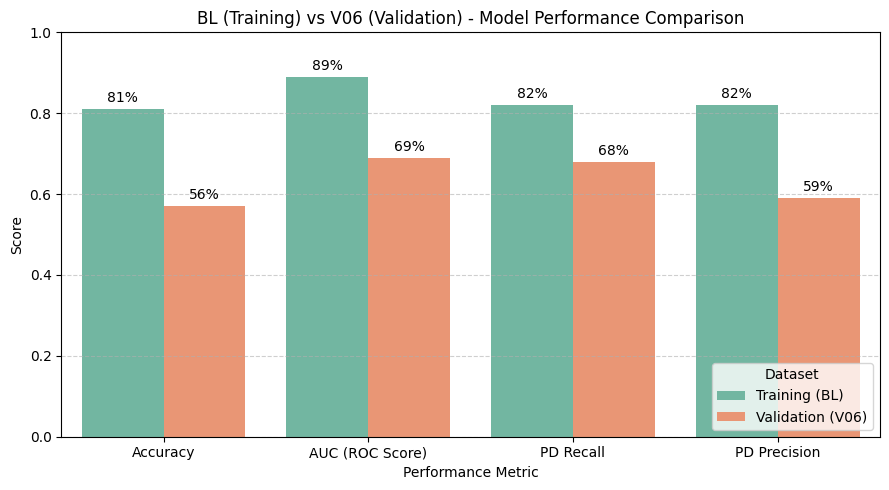

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Create the comparison data inline
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC (ROC Score)', 'PD Recall', 'PD Precision'],
    'Training (BL)': [0.81, 0.89, 0.82, 0.82],
    'Validation (V06)': [0.57, 0.69, 0.68, 0.59]
})

# ✅ Melt the DataFrame for seaborn plotting
comparison_melted = comparison_df.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

# ✅ Create the bar plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Dataset', palette='Set2')

plt.title('BL (Training) vs V06 (Validation) - Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Performance Metric')
plt.legend(title='Dataset', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# ✅ Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', padding=3, labels=[f"{int(val.get_height() * 100)}%" for val in container])

plt.tight_layout()

# ✅ Optional: Save the plot
plt.savefig('BL_vs_V06_Performance_Comparison.png', dpi=300)

# ✅ Show the plot
plt.show()


Perform Random Forest hyperparameter and create CSV

In [8]:
# perform Random Forest hyperparameter tuning with cross-validation and output accuracy and AUC scores

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Load the data
df = pd.read_csv('/content/drive/MyDrive/CSC-587/Milestone/Data/curated_log_data_bl.csv')

# Extract features and target
metabolite_columns = df.columns[4:]
metabolite_data = df[metabolite_columns].fillna(0)  # Handle NaNs
target = df['PPMI_COHORT']

# Standardize the metabolite data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(metabolite_data)

# Encode the target
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, target_encoded, test_size=0.3, random_state=42, stratify=target_encoded
)

# Define a lighter hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Evaluate the tuned model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_prob)

# Output results
print("Best Parameters:", random_search.best_params_)
print("Accuracy on Test Set:", round(accuracy, 3))
print("AUC on Test Set:", round(auc_score, 3))

# Add this snippet at the end of the script (after AUC calculation):
# Extract feature importances
import numpy as np

feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Metabolite': metabolite_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Show top 10 most important features
print("\nTop 10 Important Metabolites:")
print(importance_df.head(10))

# Export full feature importance list to CSV
# /content/drive/MyDrive/CSC-587/Milestone/Data/
# /content/drive/MyDrive/CSC-587/Milestone/Data/top30_xgboost_metabolites.csv
importance_df.to_csv('/content/drive/MyDrive/CSC-587/Milestone/Data/RandomForest_Feature_Importance.csv', index=False)
print("\nFeature importances saved to RandomForest_Feature_Importance.csv")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuracy on Test Set: 0.667
AUC on Test Set: 0.777

Top 10 Important Metabolites:
     Metabolite  Importance
1064  100020823    0.017621
1427  999924585    0.013851
718   100005996    0.010989
507   100001992    0.010134
385   100001402    0.009589
218   100000039    0.009182
1046  100020622    0.008914
497   100001925    0.008407
60          358    0.008333
1303  999917612    0.008261

Feature importances saved to RandomForest_Feature_Importance.csv


In [9]:
# Full Python Code Snippet to Add After Model Evaluation:
from scipy.stats import ttest_ind

# Run t-test for each metabolite (PD vs. Control)
control_group = df[df['PPMI_COHORT'] == 'Control'][metabolite_columns]
pd_group = df[df['PPMI_COHORT'] == 'PD'][metabolite_columns]

p_values = []
for metabolite in metabolite_columns:
    control_values = control_group[metabolite].dropna()
    pd_values = pd_group[metabolite].dropna()
    if len(control_values) > 2 and len(pd_values) > 2:
        stat, p_val = ttest_ind(control_values, pd_values, equal_var=False)
    else:
        p_val = np.nan
    p_values.append(p_val)

# Create DataFrame with p-values
pval_df = pd.DataFrame({
    'Metabolite': metabolite_columns,
    'P_Value': p_values
})

# Merge feature importance with p-values
importance_df = pd.DataFrame({
    'Metabolite': metabolite_columns,
    'Importance': feature_importances
})

combined_df = importance_df.merge(pval_df, on='Metabolite')
combined_df.sort_values(by='Importance', ascending=False, inplace=True)

# Export combined data
combined_df.to_csv('/content/drive/MyDrive/CSC-587/Milestone/Data/RF_Feature_Importance_with_PValues.csv', index=False)
print("\nCombined feature importance and p-values saved to RF_Feature_Importance_with_PValues.csv")

# Optional: Display top 10
print("\nTop 10 Metabolites by RF Importance with P-Values:")
print(combined_df.head(10))

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Combined feature importance and p-values saved to RF_Feature_Importance_with_PValues.csv

Top 10 Metabolites by RF Importance with P-Values:
     Metabolite  Importance   P_Value
1064  100020823    0.017621  0.008064
1427  999924585    0.013851  0.022838
718   100005996    0.010989  0.000664
507   100001992    0.010134  0.342784
385   100001402    0.009589  0.076261
218   100000039    0.009182  0.169452
1046  100020622    0.008914  0.004074
497   100001925    0.008407  0.007361
60          358    0.008333  0.144166
1303  999917612    0.008261  0.001017


Top 15 Metabolites

In [16]:
print(combined_df.head())
print(combined_df.columns)
print(combined_df.dtypes)

   Metabolite  Importance   P_Value
0   100020823    0.017621  0.008064
1   999924585    0.013851  0.022838
2   100005996    0.010989  0.000664
3   100001992    0.010134  0.342784
4   100001402    0.009589  0.076261
Index(['Metabolite', 'Importance', 'P_Value'], dtype='object')
Metabolite      int64
Importance    float64
P_Value       float64
dtype: object


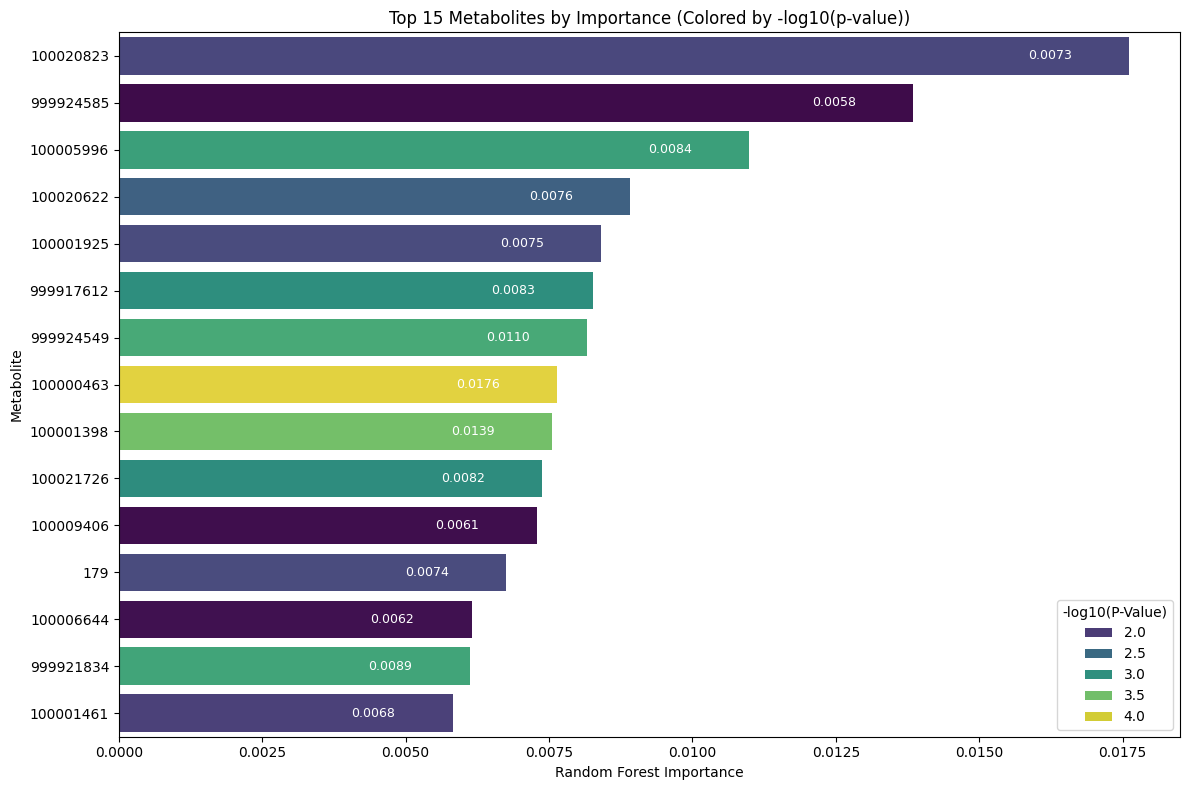

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Load your real dataset CSV
combined_df = pd.read_csv('/content/drive/MyDrive/CSC-587/Milestone/Data/RF_Feature_Importance_with_PValues.csv')

# ✅ Optional: Filter significant metabolites (p < 0.05)
filtered_df = combined_df[combined_df['P_Value'] < 0.05].copy()

# ✅ Compute -log10(p-value) for hue coloring
filtered_df['-log10(P_Value)'] = -np.log10(filtered_df['P_Value'].replace(0, np.nan))

# ✅ Get top 15 metabolites by importance
top_combined = filtered_df.sort_values(by='Importance', ascending=False).head(15)

# ✅ Sort for plotting (Seaborn plots bottom-up by default)
top_combined = top_combined.sort_values(by='Importance', ascending=True)

# ✅ Ensure metabolite order is preserved
top_combined['Metabolite'] = pd.Categorical(top_combined['Metabolite'], categories=top_combined['Metabolite'], ordered=True)

# ✅ Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=top_combined,
    y='Metabolite',
    x='Importance',
    hue='-log10(P_Value)',
    palette='viridis',
    dodge=False,
    orient='h'
)

plt.xlabel('Random Forest Importance')
plt.ylabel('Metabolite')
plt.title('Top 15 Metabolites by Importance (Colored by -log10(p-value))')
plt.legend(title='-log10(P-Value)', loc='lower right', frameon=True)

# ✅ Ensure highest importance is plotted at the top
plt.gca().invert_yaxis()

plt.tight_layout()

# ✅ Add Importance values inside the bars (aligned right inside)
for patch, importance in zip(ax.patches, top_combined['Importance']):
    width = patch.get_width()
    plt.text(width - 0.001,  # Slight offset inside the bar
             patch.get_y() + patch.get_height() / 2,
             f"{importance:.4f}",
             va='center', ha='right', fontsize=9, color='white')  # White text for contrast

plt.show()
